# Домашняя работа №3

При отправлении ДЗ в Dropbox указывайте фамилию в названии файла: <br\>
** IDA<Номер группы>HW3<Фамилия>.ipynb ** - например ** IDA3HW3Pupkin.ipynb **<br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

# Преамбула

Автоэнкодеры - это полносвязные сети, задачей которых является на выходе сети восстановить объекты, поданные на вход. Такие сети состоят из двух частей - енкодера и декодера. В каждом следующем слое энкодера становится всё меньше и меньше нейронов, в результате чего происходит "сжатие" исходной информации. В самом сжатом виде информация находится на последнем слое энкодера который называется bottleneck(с англ. бутылочное горлышко). Далее информация из bottleneck'a подаётся на вход декодеру, у которого наоборот с каждый следующим слоем количество нейронов становится больше и больше. Размерности выходов и входов такой нейронной сети совпадают. 

<img src="autoencoder.png">

Активации нейронов с самого узкого слоя можно использовать как довольно качественные признаки для передачи в другие модели машинного обучения.

Целью данного домашнего задания является реализация нескольких вариантов автокодировщиков, проведение экспериментов с целью определения структур, которые выучивают нейроны. 

In [1]:
import numpy

import keras

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Загрузка и предобработка данных (2.5 балла).

Загрузите *images.pkl*. Данный файл содержит набор фото. 

In [2]:
import pickle as pkl
import numpy as np

images = np.load(open('images.npy', 'br'))

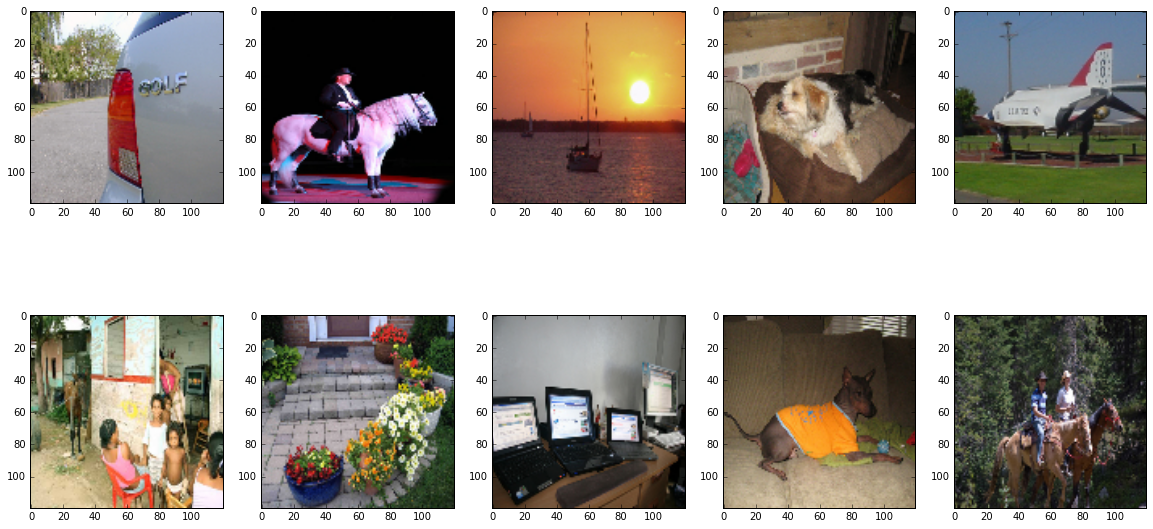

In [3]:
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])

## Генерация датасета (2 балла)

Напишите функцию, которая принимает на вход исходный набор фотографий из возращает нужное количество "сэмплов" - случайных квадратных подкартинок нужного размера. Визуализируйте несколько сэмплов.

In [4]:
import random

In [5]:
def get_samples(full_images, num_samples=100000, sample_size=16, rand_seed=123):
    random.seed(rand_seed)
    new_images = []
    patches = []
    for sample in range(num_samples):
        image = full_images[random.randint(0, 6999)]
        rand = random.randint(1, 120 - sample_size)
        new_patch = image[rand:rand + sample_size, rand:rand + sample_size]
        patches.append(new_patch)
    return patches

In [6]:
new_samples = get_samples(images)

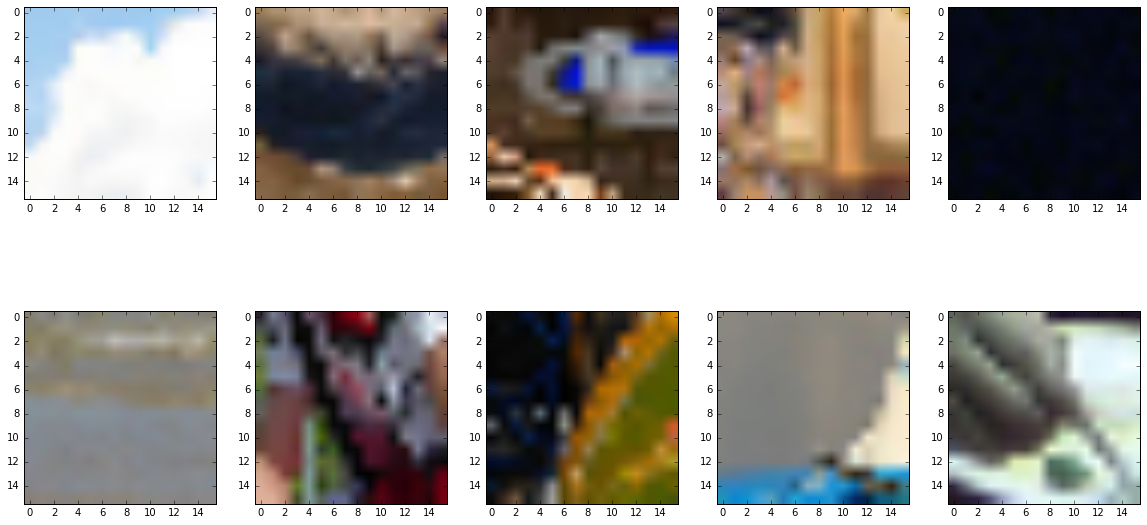

In [7]:
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(new_samples[i + 3])

## Нормировка картинок и вытягивание их в один вектор (0.5 балл)

Переведите интенсивности каждого канала (R, G, B) в отрезок $[0.1, 0.9]$. Значения отбрасывать не надо, просто отшкалируйте каналы.

In [8]:
from sklearn.preprocessing import MinMaxScaler
rgb_scaler = MinMaxScaler((0.1, 0.9))

new_samples = np.asarray(new_samples)
testing = new_samples.reshape(1, 1, -1, 3)

new_testing = rgb_scaler.fit_transform(testing[0][0])
new_testing = new_testing.reshape(100000, 16, 16, 3)

Преобразуйте каждый семпл-матрицу в вектор.

То есть из исходного набора сэмплов размера [num_samples, sample_size, sample_size, 3] должен получиться набор размера [num_samples, sample_size x sample_size x 3].

In [9]:
new_vectors = new_testing.reshape(100000, 16*16*3)

# Реализация и обучение автокодировщика (4 балла)

### Построение автокодировщика (1.5 балла)

Напишите функцию, которая принимает параметры автокодировщика(размер входа и выхода, количества нейронов в каждом слое энкодера, количество нейронов в каждом слое декодера). Внутри автокодировщика использовать нелинейности-RELU. Но для выходов автоэнкодера использовать сигмоиду.

Выход функции - Keras модель, скомпилированная чтобы минимизировать MSE на трэйне. Оптимизатор - на ваш выбор.

In [10]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential

In [11]:
def create_autoencoder_model(object_size, encoder_layer_shapes, decoder_layer_shapes):
    model = Sequential()
    
    input_img = Input(shape=(object_size,))
    encoded = Dense(encoder_layer_shapes[0], activation='relu')(input_img)

    for i in encoder_layer_shapes[1:]:
        encoded = Dense(i, activation='relu')(encoded)

    decoded = Dense(decoder_layer_shapes[0], activation='relu')(encoded)

    for j in decoder_layer_shapes[1:]:
        decoded = Dense(j, activation='relu')(decoded)

    decoded = Dense(object_size, activation='sigmoid')(decoded)
    model = Model(input_img, decoded)
    
    return model

Разделите выборку из сэмплов на тренировочную выборку и валидационную отношении 90%-10%.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(new_vectors, test_size = 0.1, random_state = 123)

Обучите модель со стандартными параметрами.

In [13]:
model = create_autoencoder_model(768, [2**8, 2**7, 2**6], [200, 400])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, X_train, validation_data=(X_test, X_test), epochs=5)

Train on 90000 samples, validate on 10000 samples
Epoch 1/5
90000/90000 [==============================] - 42s 471us/step - loss: 0.0093 - val_loss: 0.0069
Epoch 2/5
90000/90000 [==============================] - 43s 483us/step - loss: 0.0063 - val_loss: 0.0059
Epoch 3/5
90000/90000 [==============================] - 39s 429us/step - loss: 0.0058 - val_loss: 0.0057
Epoch 4/5
90000/90000 [==============================] - 42s 471us/step - loss: 0.0056 - val_loss: 0.0055
Epoch 5/5
90000/90000 [==============================] - 43s 472us/step - loss: 0.0054 - val_loss: 0.0053


### Визуализация паттернов, которые находят нейроны (1.5 балла)

Возьмите несколько объектов из валидационной выборки и прогоните через автоэнкодер. Оцените визуально результат восстановления объектов.

In [19]:
decoded_images = model.predict(X_test)

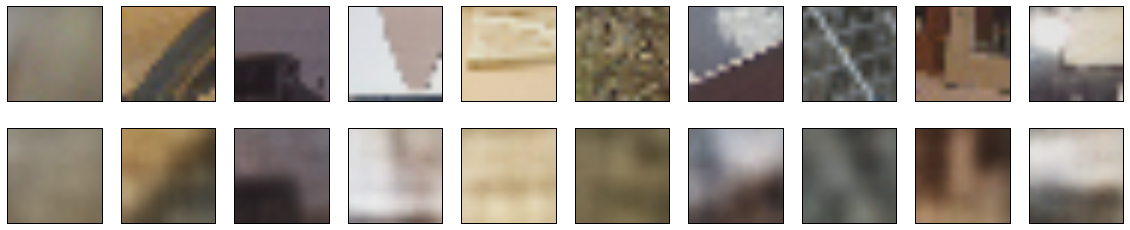

In [20]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i + 1212].reshape(16, 16, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i + 1212].reshape(16, 16, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

Для каждого слоя и для каждого нейрона на этом слое найдите объект из тренировочной выборки, на котором этот нейрон выдаёт наибольшую активацию. Если нейрон ни на одном объекте не активировался, пропустите изображение для него. Что можете сказать про сложность шаблонов на объектах для каждого слоя?

In [21]:
from keras import backend as K

layers = []
# найдем выходы каждого нейрона на каждом слое
for i in range(7):
    get_layer_output = K.function([model.layers[0].input],
                                  [model.layers[i].output])
    layers.append(get_layer_output([X_test])[0])

### Исследование зависимости качества восстановления от параметров автоэнкодера (1 балл)


Обучите несколько автоэнкодеров с различным количеством слоёв, разными размерами bottleneck'a и сравните, насколько быстро модели обучаются и финальный лосс на валидационной выборке. Какие выводы вы можете сделать?

In [22]:
first = create_autoencoder_model(768, [2**8, 2**7], [200, 400])
first.compile(optimizer='adam', loss='mean_squared_error')
first.fit(X_train, X_train, validation_data=(X_test, X_test), epochs=2)

Train on 90000 samples, validate on 10000 samples
Epoch 1/2
90000/90000 [==============================] - 43s 482us/step - loss: 0.0084 - val_loss: 0.0058
Epoch 2/2
90000/90000 [==============================] - 39s 434us/step - loss: 0.0053 - val_loss: 0.0049


In [23]:
second = create_autoencoder_model(768, [2**8, 2**7, 2**6], [200, 400])
second.compile(optimizer='adam', loss='mean_squared_error')
second.fit(X_train, X_train, validation_data=(X_test, X_test), epochs=2)

Train on 90000 samples, validate on 10000 samples
Epoch 1/2
90000/90000 [==============================] - 37s 412us/step - loss: 0.0095 - val_loss: 0.0069
Epoch 2/2
90000/90000 [==============================] - 38s 424us/step - loss: 0.0065 - val_loss: 0.0060


In [24]:
third = create_autoencoder_model(768, [2**8, 2**7, 2**6, 2**5], [200, 400])
third.compile(optimizer='adam', loss='mean_squared_error')
third.fit(X_train, X_train, validation_data=(X_test, X_test), epochs=2)

Train on 90000 samples, validate on 10000 samples
Epoch 1/2
90000/90000 [==============================] - 41s 457us/step - loss: 0.0110 - val_loss: 0.0087
Epoch 2/2
90000/90000 [==============================] - 38s 422us/step - loss: 0.0086 - val_loss: 0.0083


***C увеличением количества слоев в энкодере растет как и время обучения, так и ошибка на тесте. ***

# Классификация MNIST и CIFAR (3,5 балла)

### MNIST (2 балла)

Загрузите датасет MNIST и провизуализируйте несколько цифр.

In [25]:
from keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

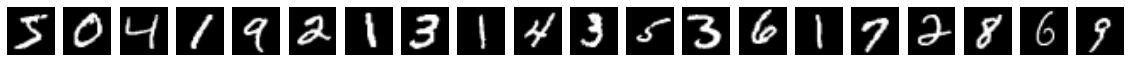

In [26]:
n = 20
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Сожмите данные автокодировщиком, у которого только один скрытый слой (по сути только bottleneck) с 30 нейронами.

In [27]:
x_train = x_train.reshape((len(x_train), 784)) / 255
x_test = x_test.reshape((len(x_test), 784)) / 255

In [28]:
input_img = Input(shape=(784,))
encoded = Dense(30, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)

In [29]:
encoder = Model(input_img, encoded)

Возьмите несколько моделей из sklearn (KNN, SVM, RandomForest, GradientBoosting/XGBClassifier) и обучите модель со стандартными параметрами на выходах энкодера. Какие у вас получились результаты (точность) на тесте? *** SVM не обучал, так как слишком долго ноутбук фризил на нем***.

In [30]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(x_train, x_train, epochs=10, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.0326 - val_loss: 0.0170
Epoch 2/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.0142 - val_loss: 0.0121
Epoch 3/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.0120 - val_loss: 0.0113
Epoch 4/10
60000/60000 [==============================] - 8s 130us/step - loss: 0.0115 - val_loss: 0.0110
Epoch 5/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.0113 - val_loss: 0.0109
Epoch 6/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.0112 - val_loss: 0.0109
Epoch 7/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.0111 - val_loss: 0.0108
Epoch 8/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.0111 - val_loss: 0.0108
Epoch 9/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.0110 - val_loss: 0.0

In [31]:
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)

(_, y_train), (_, y_test) = mnist.load_data()

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [33]:
knn = KNeighborsClassifier().fit(encoded_train, y_train)

In [34]:
rfc = RandomForestClassifier().fit(encoded_train, y_train)

In [35]:
gbc = GradientBoostingClassifier().fit(encoded_train, y_train)

In [36]:
print('Доля правильных классификаций для knn', accuracy_score(knn.predict(encoded_test), y_test))

Доля правильных классификаций для knn 0.9687


In [37]:
print('Доля правильных классификаций для случайного леса', accuracy_score(rfc.predict(encoded_test), y_test))

Доля правильных классификаций для случайного леса 0.914


In [38]:
print('Доля правильных классификаций для gbc', accuracy_score(gbc.predict(encoded_test), y_test))

Доля правильных классификаций для gbc 0.9162


### CIFAR10 (2 балла)

Загрузите CIFAR10 и обучите автоэнкодер на случайных сэмплах размера 8x8 из этого датасета. Архитектура автоэнкодера как в прошлом пункте - только один внутренний слой из 30 нейронов.

In [39]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [40]:
def get_cifar_samples(full_images, num_samples=10000, sample_size=8, rand_seed=123):
    random.seed(rand_seed)
    new_images = []
    patches = []
    for sample in range(num_samples):
        image = full_images[random.randint(0, 49999)]
        rand = random.randint(1, 32 - sample_size)
        new_patch = image[rand:rand + sample_size, rand:rand + sample_size]
        patches.append(new_patch)
    return patches

In [43]:
cifar_samples = get_cifar_samples(x_train, 10000, 8)
cifar_samples = np.asarray(cifar_samples)
cifar_samples = cifar_samples.reshape(len(cifar_samples), 192) / 255

In [46]:
X_train, X_test = train_test_split(cifar_samples, test_size = 0.1, random_state = 123)

In [47]:
input_img = Input(shape=(192,))
encoded = Dense(30, activation='relu')(input_img)
decoded = Dense(192, activation='sigmoid')(encoded)
autoencoder_cifar = Model(input_img, decoded)

autoencoder_cifar.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_cifar.fit(X_train, X_train, epochs=5, validation_data=(X_test, X_test))

Train on 9000 samples, validate on 1000 samples
Epoch 1/5
9000/9000 [==============================] - 1s 116us/step - loss: 0.0439 - val_loss: 0.0254
Epoch 2/5
9000/9000 [==============================] - 1s 76us/step - loss: 0.0165 - val_loss: 0.0105
Epoch 3/5
9000/9000 [==============================] - 1s 80us/step - loss: 0.0086 - val_loss: 0.0071
Epoch 4/5
9000/9000 [==============================] - 1s 79us/step - loss: 0.0066 - val_loss: 0.0062
Epoch 5/5
9000/9000 [==============================] - 1s 79us/step - loss: 0.0056 - val_loss: 0.0051


Теперь разделите каждую картинку из датасета на 16 сэмплов размера 8x8, закодируйте их через энкодер и склейте 16 выходов энкодера в один вектор. Каждый объект в итоге должен кодироваться 16 * 30 = 380 признаками.

*** У всех крашится все при работе с полным набором данных => возьмем несколько объектов из трейна и теста. ***

In [48]:
subset_train = x_train[0:5000] / 255
subset_test = x_test[0:1000] / 255

In [49]:
patches_train, patches_test = [], []

for sample in range(len(subset_train)):
    image = subset_train[sample]
    for i in range(16):
        rand = random.randint(1, 32 - 8)
        new_patch = image[rand:rand + 8, rand:rand + 8]
        patches_train.append(new_patch)
        
for sample in range(len(subset_test)):
    image = subset_test[sample]
    for i in range(16):
        rand = random.randint(1, 32 - 8)
        new_patch = image[rand:rand + 8, rand:rand + 8]
        patches_test.append(new_patch)
        
patches_train = np.array(patches_train)
patches_test = np.array(patches_test)

In [50]:
patches_train = patches_train.reshape(len(patches_train), 192)
patches_test = patches_test.reshape(len(patches_test), 192)

In [51]:
encoder_cifar = Model(input_img, encoded)
cifar_train = encoder_cifar.predict(patches_train)
cifar_test = encoder_cifar.predict(patches_test)

In [52]:
cif_train = cifar_train.reshape(len(subset_train), 30*16)
cif_test = cifar_test.reshape(len(subset_test), 30*16)

Теперь обучите SVM на преобразованных объектах и выведите точность.

In [53]:
y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = y_train.reshape(len(y_train), )
y_test = y_test.reshape(len(y_test), )

In [54]:
y_sub_train = y_train[0:5000]
y_sub_test = y_test[0:1000]

In [55]:
y_subtrain = y_sub_train.reshape(5000, )
y_subtest = y_sub_test.reshape(1000, )

In [56]:
from sklearn.svm import SVC
svc = SVC().fit(cif_train, y_subtrain)

In [57]:
print('Доля правильных классификаций на тесте для svc', accuracy_score(svc.predict(cif_test), y_subtest))

Доля правильных классификаций на тесте для svc 0.223


In [58]:
print('Доля правильных классификаций на трейне для svc', accuracy_score(svc.predict(cif_train), y_subtrain))

Доля правильных классификаций на трейне для svc 0.727
